<a href="https://colab.research.google.com/github/bye23mj/suanLee/blob/main/TF_10_3_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_%EC%82%AC%EC%A0%84%ED%9B%88%EB%A0%A8_%EB%AA%A8%EB%8D%B8_%EC%82%AC%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

## modules import

In [ ]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

## GPU 설정

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

#with strategy.scope():

## 데이터 로드 및 확인

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data -d .

## 전처리 설정

In [ ]:
data_transforms = {'train' : transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   'val' : transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [ ]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x],
                             batch_size=4,
                             shuffle=True,
                             num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(class_names)

['ants', 'bees']


## 사전훈련된 모델 로드

In [ ]:
with strategy.scope():
  model_ft = models.resnet18(pretrained=True)

- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [ ]:
model_ft

- 

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [ ]:
num_ftrs = model_ft.fc.in_features
model_ft.tc = nn.Linear(num_ftrs, 2)

#model_ft = model_ft.to(device)

## 손실함수와 옵티마이저

In [ ]:
cirterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

-  7 에폭마다 0.1씩 학습율 감소

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 모델 학습

- 학습 함수 정의

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        #inputs = inputs.to(device)
        #labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]  
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f}\tAccuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc :
        best_acc == epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  time_elapsed = time.time() - since
  print('Training time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best Validation Accuracy : {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [ ]:
with strategy.scope():
  model_ft = train_model(model_ft, cirterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8057	Accuracy: 0.7049
val Loss: 0.8324	Accuracy: 0.6732

Epoch 1/24
----------
train Loss: 0.7041	Accuracy: 0.7336
val Loss: 0.6186	Accuracy: 0.7843

Epoch 2/24
----------
train Loss: 0.5539	Accuracy: 0.7869
val Loss: 0.4354	Accuracy: 0.8366

Epoch 3/24
----------
train Loss: 0.5316	Accuracy: 0.7746
val Loss: 1.0455	Accuracy: 0.7124

Epoch 4/24
----------
train Loss: 0.5822	Accuracy: 0.7623
val Loss: 0.3244	Accuracy: 0.8627

Epoch 5/24
----------
train Loss: 0.6108	Accuracy: 0.7336
val Loss: 1.0351	Accuracy: 0.6340

Epoch 6/24
----------
train Loss: 0.4386	Accuracy: 0.7992
val Loss: 0.4230	Accuracy: 0.8431

Epoch 7/24
----------
train Loss: 0.3021	Accuracy: 0.8811
val Loss: 0.2596	Accuracy: 0.8889

Epoch 8/24
----------
train Loss: 0.3866	Accuracy: 0.8443
val Loss: 0.2860	Accuracy: 0.8889

Epoch 9/24
----------
train Loss: 0.3503	Accuracy: 0.8361
val Loss: 0.2628	Accuracy: 0.8954

Epoch 10/24
----------
train Loss: 0.3506	Accuracy: 0.8074
val Loss: 0.2989	Accuracy: 0.8562

## 결과 시각화

- 시각화 함수 정의

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  fig = plt.figure(figsize=(10, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


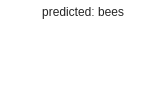

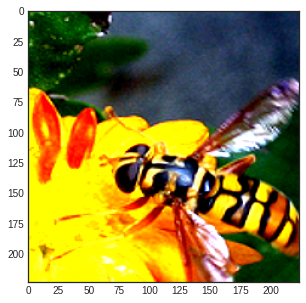

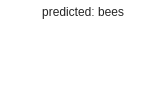

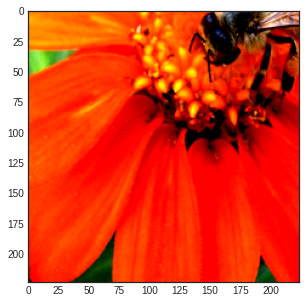

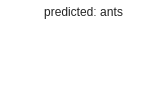

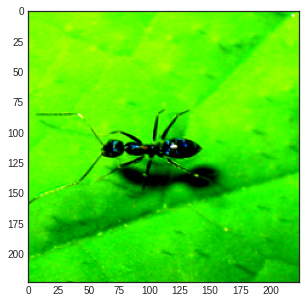

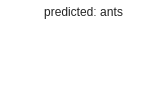

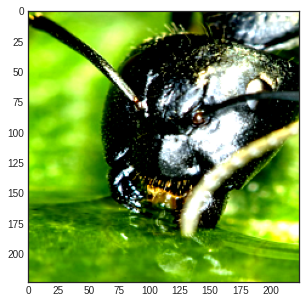

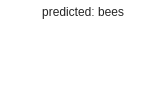

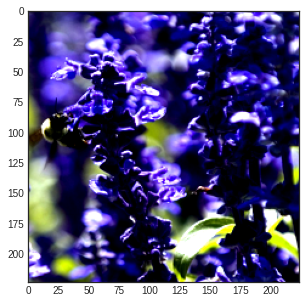

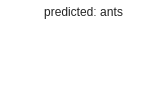

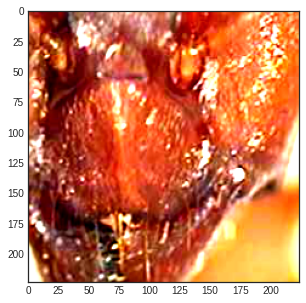

In [ ]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망
- 마지막 계층을 제외한 신경망의 모든 부분을 고정

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [ ]:
with strategy.scope():
  model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

#model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5579	Accuracy: 0.7295
val Loss: 0.2695	Accuracy: 0.9020

Epoch 1/24
----------
train Loss: 0.4000	Accuracy: 0.8402
val Loss: 0.2164	Accuracy: 0.9085

Epoch 2/24
----------
train Loss: 0.5189	Accuracy: 0.7705
val Loss: 0.2361	Accuracy: 0.9477

Epoch 3/24
----------
train Loss: 0.6320	Accuracy: 0.7295
val Loss: 0.2463	Accuracy: 0.9020

Epoch 4/24
----------
train Loss: 0.4165	Accuracy: 0.8115
val Loss: 0.2050	Accuracy: 0.9346

Epoch 5/24
----------
train Loss: 0.2993	Accuracy: 0.8689
val Loss: 0.3724	Accuracy: 0.8431

Epoch 6/24
----------
train Loss: 0.5375	Accuracy: 0.7705
val Loss: 0.3903	Accuracy: 0.8627

Epoch 7/24
----------
train Loss: 0.6106	Accuracy: 0.7623
val Loss: 0.1840	Accuracy: 0.9346

Epoch 8/24
----------
train Loss: 0.4125	Accuracy: 0.8115
val Loss: 0.1264	Accuracy: 0.9542

Epoch 9/24
----------
train Loss: 0.4359	Accuracy: 0.8156
val Loss: 0.1871	Accuracy: 0.9346

Epoch 10/24
----------
train Loss: 0.3383	Accuracy: 0.8484
val Loss: 0.2126	Accuracy: 0.9216

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


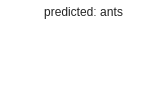

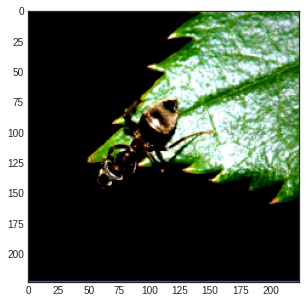

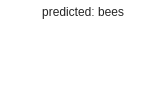

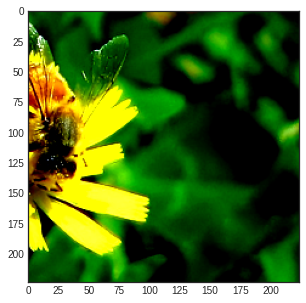

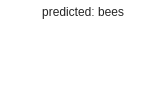

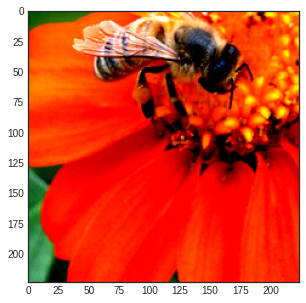

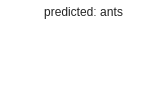

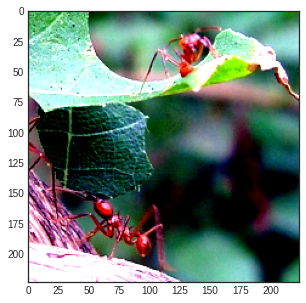

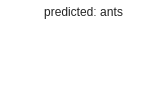

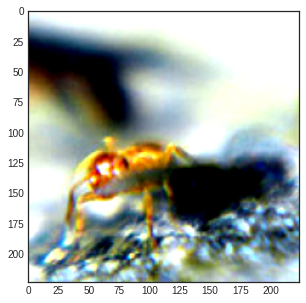

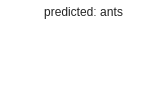

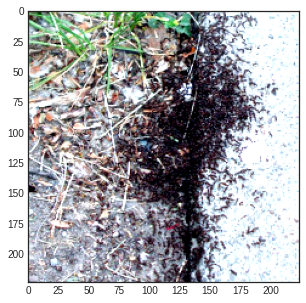

In [ ]:
visualize_model(model_conv)